In [1]:
# Required packages
import pandas as pd
import numpy as np 
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
# from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

warnings.filterwarnings('ignore')

/Users/yangtianyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/yangtianyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
start = datetime.datetime(2017,1,1)#获取数据的时间段-起始时间
end = datetime.date.today()#获取数据的时间段-结束时间
df = data.get_data_yahoo('BTC-USD', start=start, end=end)

# Calculate RV
## 如果是tick或min_bar:  
$RV_{daily} = \sum{\ln({\frac{close_t}{close_{t-1}}})}$  
$RV_{annulized} = RV_{daily} * \sqrt{365}$  

## 如果是daily_data:
1. 先计算log return  
$ return_{log} = \ln({\frac{close_t}{close_{t-1}}})$   

2. daily vol  
$RV_{daily} = return_{log}.std() * \sqrt{365}$  

3. 计算滚动RV  
$RV_n = return_{log}.rolling(n).std() * \sqrt{365}$ 


In [3]:
df['log_ret'] = np.log(df['Close']/df['Close'].shift())
df['rv_daily'] = df['log_ret'].rolling(2).std() * np.sqrt(365)
df['rv_5'] = df['log_ret'].rolling(5).std() * np.sqrt(365)
df['rv_20'] = df['log_ret'].rolling(20).std() * np.sqrt(365)

df

Attributes,Adj Close,Close,High,Low,Open,Volume,log_ret,rv_daily,rv_5,rv_20
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,
Date,,,,,,,,,,
2016-12-31,963.742981,963.742981,963.742981,947.236023,960.627014,9.913510e+07,NaN,NaN,NaN,NaN
2017-01-01,998.325012,998.325012,1003.080017,958.698975,963.658020,1.477750e+08,0.035254,NaN,NaN,NaN
2017-01-02,1021.750000,1021.750000,1031.390015,996.702026,998.617004,2.221850e+08,0.023193,0.162935,NaN,NaN
2017-01-03,1043.839966,1043.839966,1044.079956,1021.599976,1021.599976,1.851680e+08,0.021389,0.024369,NaN,NaN
2017-01-04,1154.729980,1154.729980,1159.420044,1044.400024,1044.400024,3.449460e+08,0.100960,1.074945,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-07-22,22714.978516,22714.978516,23671.927734,22603.416016,23163.751953,3.142156e+10,-0.019602,0.225731,0.777982,0.611430
2022-07-23,22465.478516,22465.478516,22977.210938,22002.910156,22706.984375,2.402180e+10,-0.011045,0.115602,0.439100,0.616666


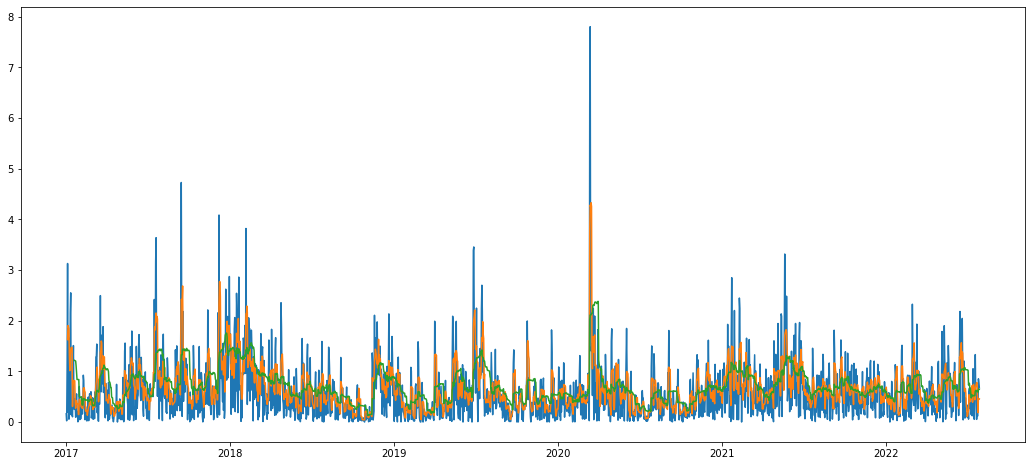

In [4]:
plt.figure(figsize = (18,8))
plt.plot(df[['rv_daily','rv_5','rv_20']])
plt.show()

In [34]:
p25 = []
p50 = []
p75 = []
p100 = []
for i in range(21,len(df)):
    tmp = df.iloc[(i-21):i,:]
    tmp = tmp.sort_values(by='rv_daily')
    p2 = tmp.iloc[round(i*0.25),-3]
    p5 = tmp.iloc[round(i*0.50),-3]
    p7 = tmp.iloc[round(i*0.75),-3]
    p10 = tmp.iloc[round(i-1),-3]
    p25.append(p2)
    p50.append(p5)
    p75.append(p7)
    p100.append(p10)
plt.plot(p25)

IndexError: index 21 is out of bounds for axis 0 with size 21

In [65]:
rv = pd.DataFrame()
rv = pd.concat([rv,df['rv_daily'],df['rv_5'],df['rv_20']],axis=1)
rv["Target"] = rv["rv_daily"].shift() #We want to predict the RV of the next day.  
rv.dropna(inplace = True)
rv

,rv_daily,rv_5,rv_20,Target
2017-01-20,0.249401,0.809890,1.217646,0.509460
2017-01-21,0.458978,0.813430,1.214334,0.249401
2017-01-22,0.355831,0.380991,1.208718,0.458978
2017-01-23,0.095792,0.273351,1.202926,0.355831
2017-01-24,0.368398,0.414136,1.105163,0.095792
...,...,...,...,...
2022-07-17,0.492158,0.438338,0.521199,0.053741
2022-07-18,1.330724,0.681956,0.609606,0.492158
2022-07-19,0.533810,0.696345,0.623061,1.330724
2022-07-20,0.623729,0.747650,0.617568,0.533810


# HAR  
$\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m + \hat{\beta_4}IV_t + \hat{\beta_5}VOL_t $ 

In [66]:
#Add constant c
rv = sm.add_constant(rv)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv.drop("Target", axis = 1)
y = rv[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [67]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     325.5
Date:                Thu, 21 Jul 2022   Prob (F-statistic):          1.21e-154
Time:                        15:21:43   Log-Likelihood:                -789.96
No. Observations:                1205   AIC:                             1588.
Df Residuals:                    1201   BIC:                             1608.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0255      0.030     -0.849      0.396      -0.084       0.033
rv_daily       0.0052      0.030      0.174      0.862      -0.053       0.063
rv_5           0.8358      0.046     18.014      0.000       0.745       0.927
rv_20          0.0394      0.049      0.804      0.422      -0.057       0.135
==============================================================================
Omnibus:                      318.475   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5529.308
Skew:                           0.749   Prob(JB):                         0.00
Kurtosis:                      13.387   Cond. No.                         7.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

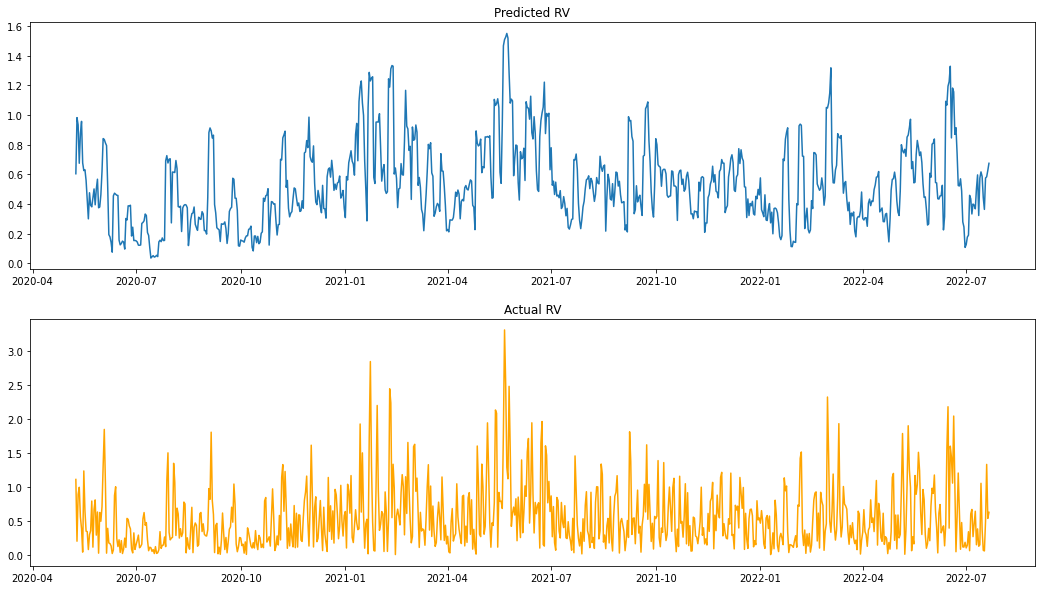

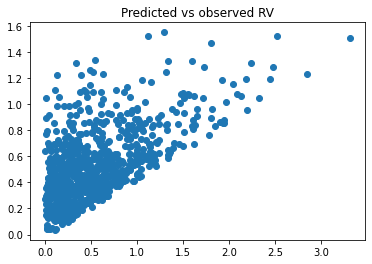

In [72]:
y_hat = results.predict(X_test)

plt.figure(figsize = (18,10))

#Predicted RV
plt.subplot(2,1,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(2,1,2)
plt.plot(y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [73]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [74]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.21724095812732427, R^2:0.448468596058183, MAE:0.3182114388066182
----------------
Out-of-sample scores
MSE:0.14209867133066112, R^2:0.36125721029070834, MAE:0.2865106092622412


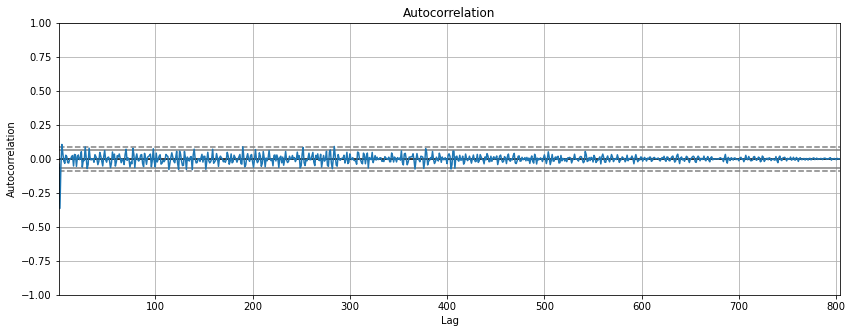

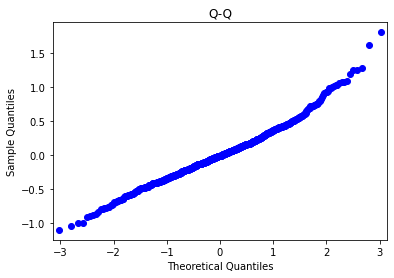

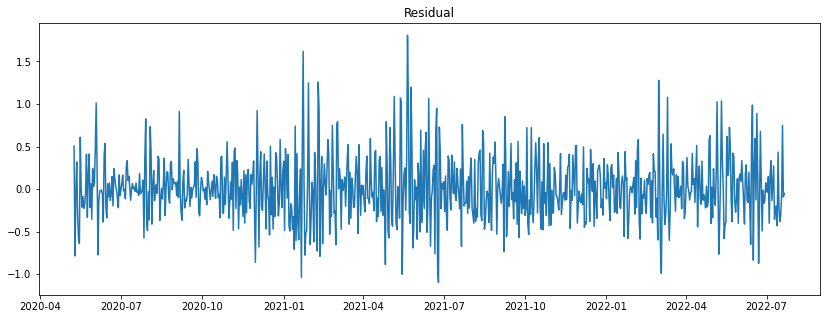

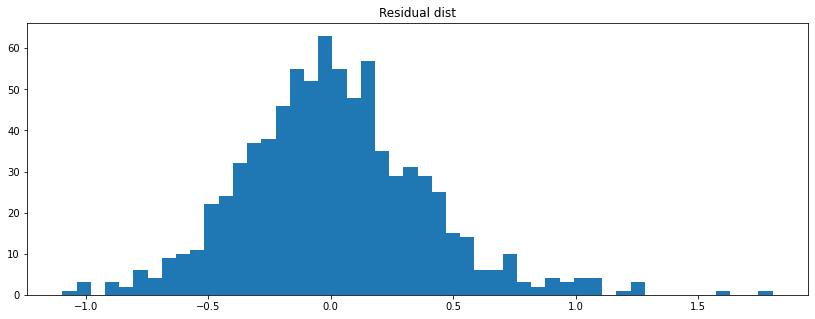

In [75]:
# Residuals
residuals = y_test.values.ravel() - y_hat

plt.figure(figsize = (14,5));autocorrelation_plot(residuals);plt.title("Autocorrelation");plt.show()
qqplot(residuals);plt.title("Q-Q");plt.show()
plt.figure(figsize = (14,5));plt.plot(residuals);plt.title("Residual");plt.show()
plt.figure(figsize = (14,5));plt.hist(residuals, bins = 50); plt.title("Residual dist");plt.show()